In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_predict,
                                     cross_val_score,
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

sns.set_style('whitegrid')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex

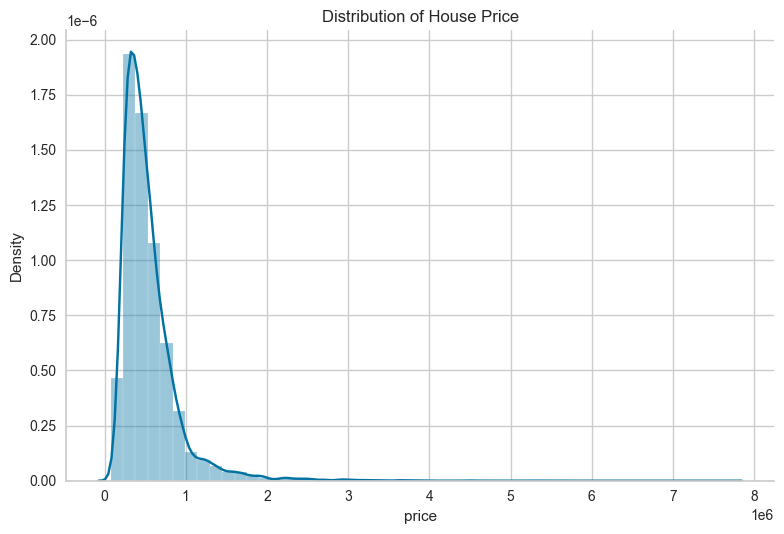

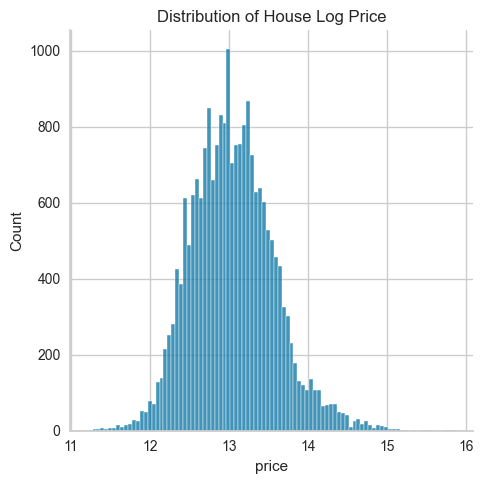

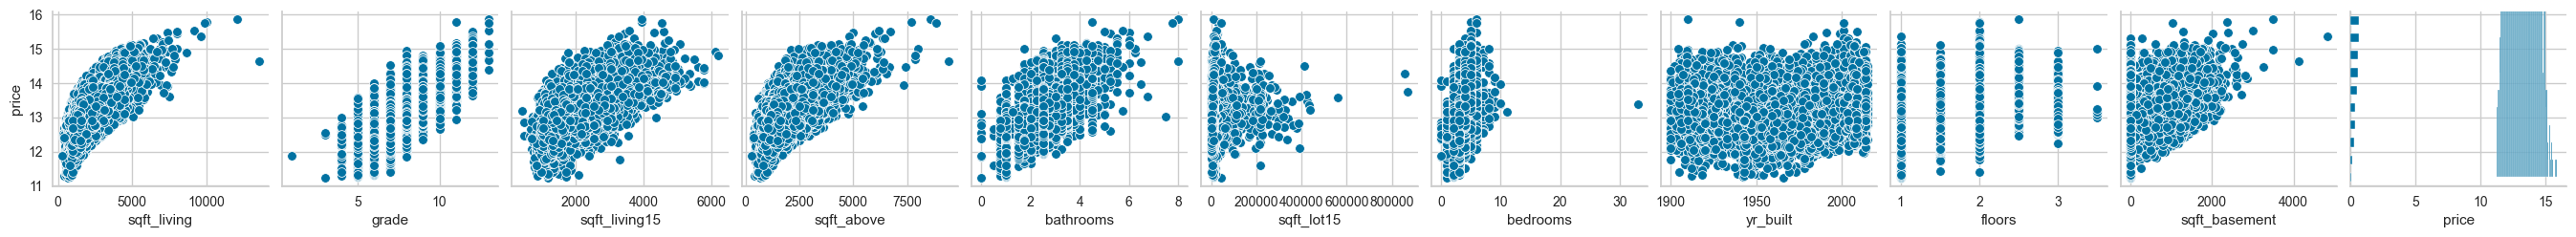

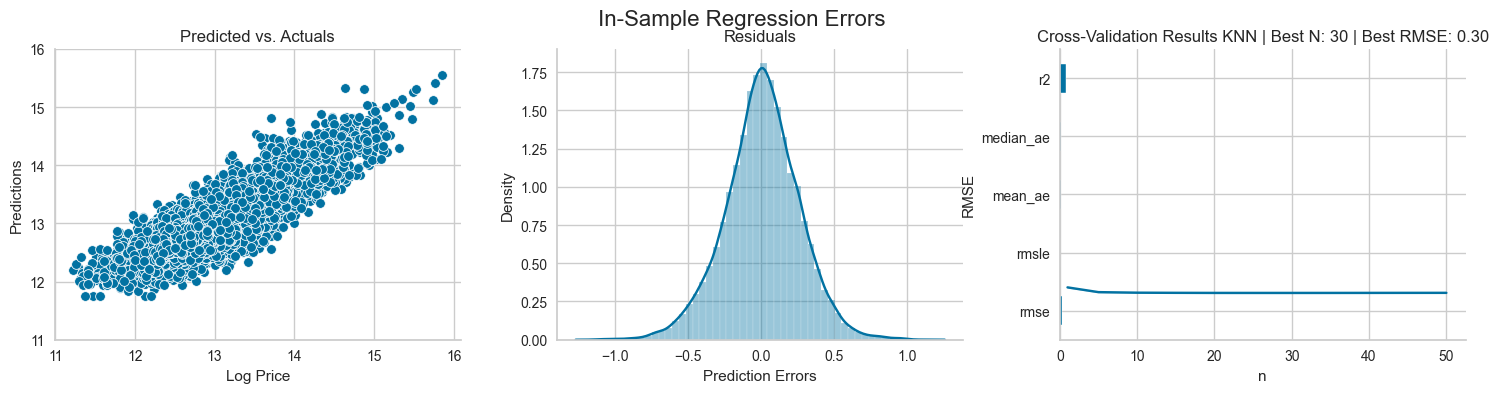

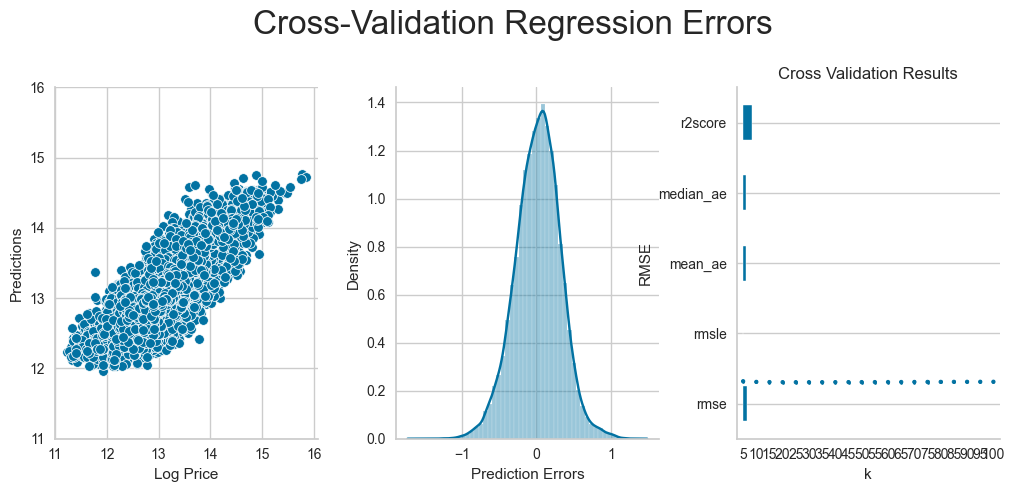

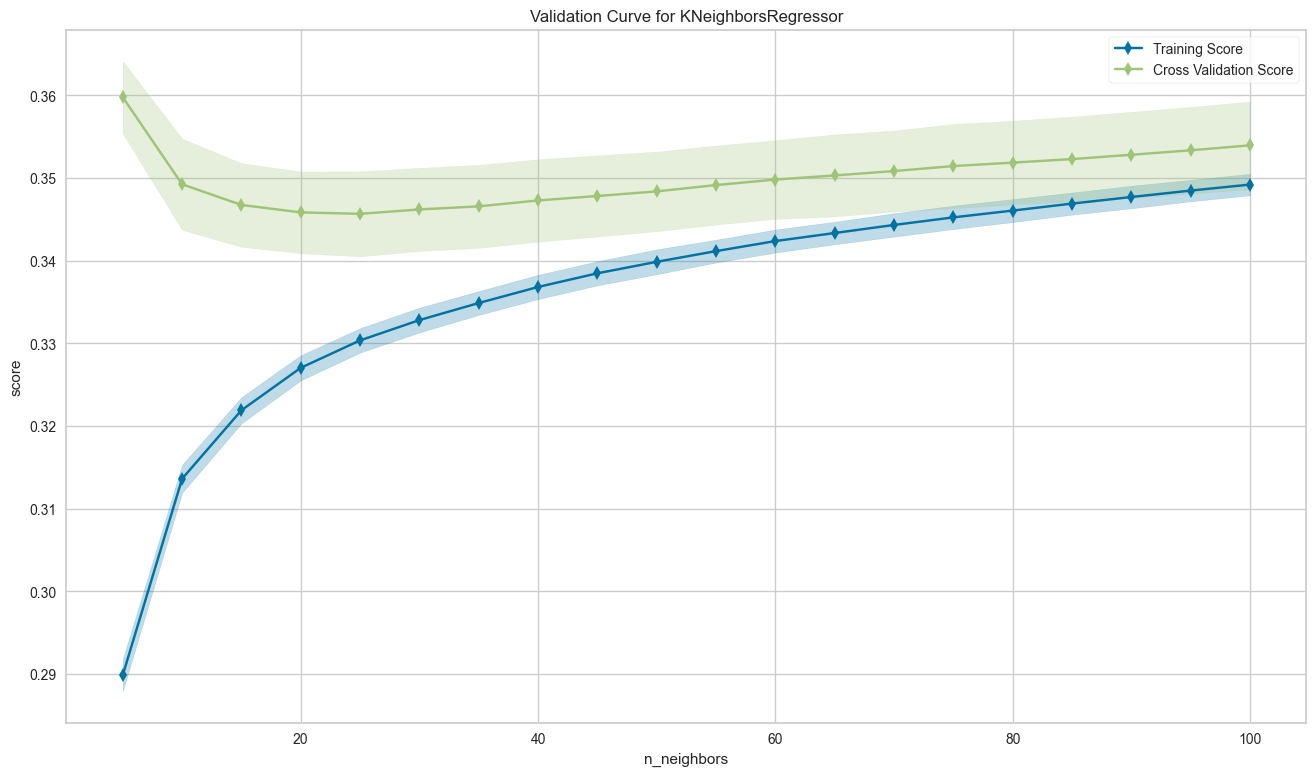

<Figure size 800x550 with 0 Axes>

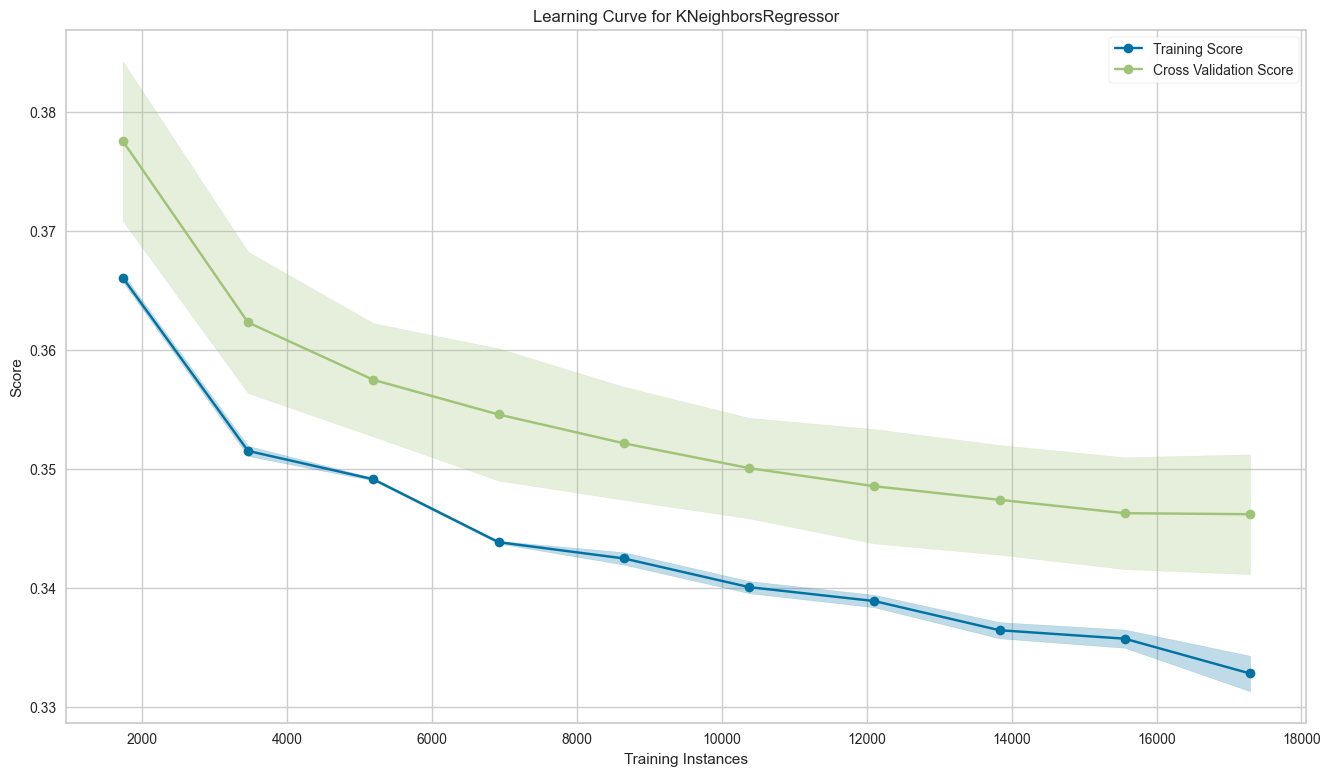

<Figure size 800x550 with 0 Axes>

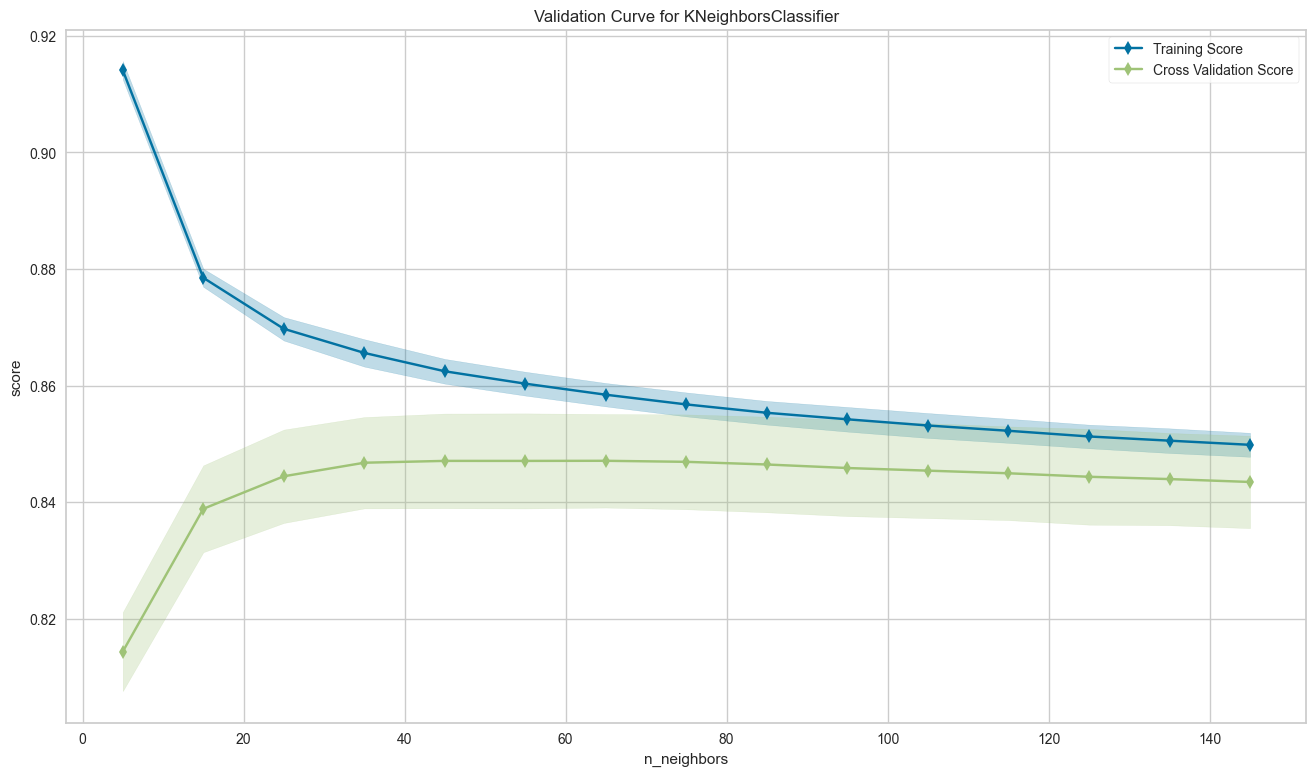

<Figure size 800x550 with 0 Axes>

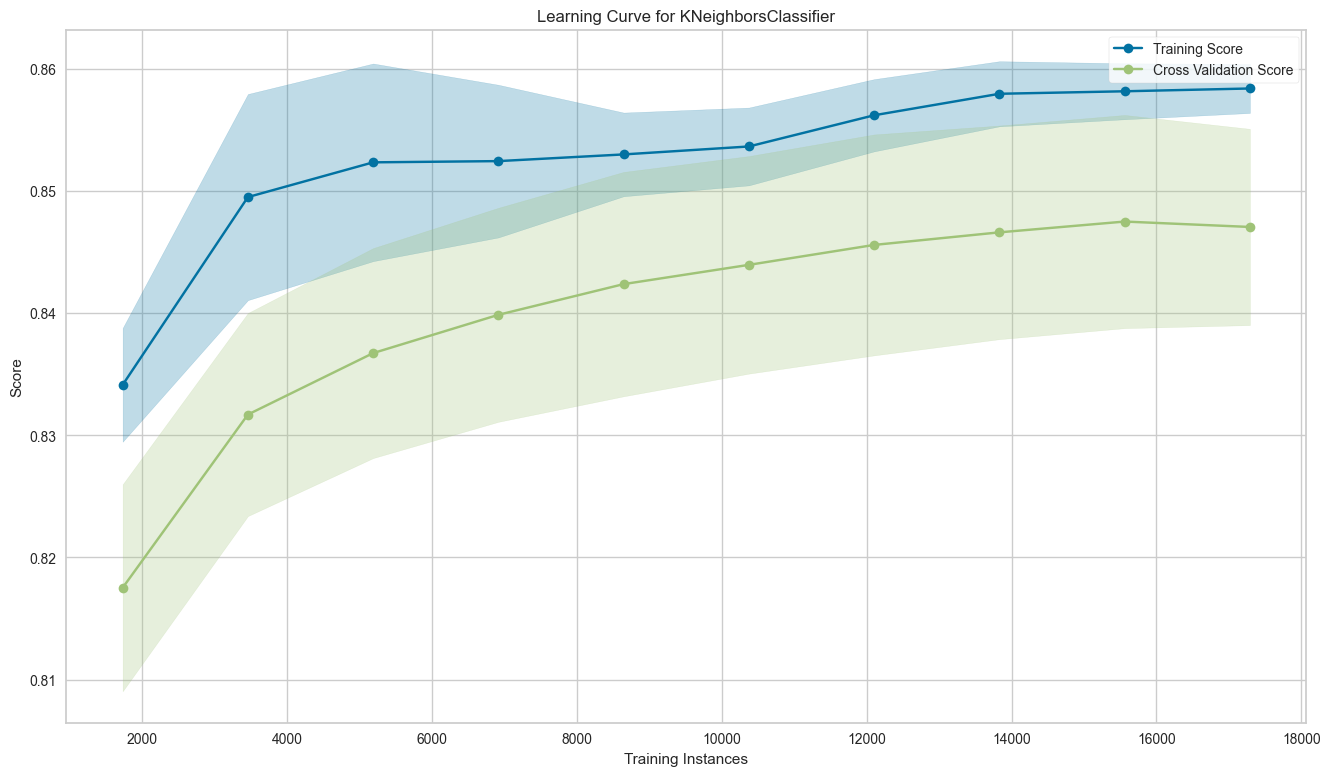

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   False Positive Rate  67 non-null     float64
 1   True Positive Rate   67 non-null     float64
 2   threshold            67 non-null     float64
dtypes: float64(3)
memory usage: 1.7 KB
              precision    recall  f1-score   support

           0       0.82      0.63      0.71     10864
           1       0.70      0.86      0.77     10749

    accuracy                           0.74     21613
   macro avg       0.76      0.74      0.74     21613
weighted avg       0.76      0.74      0.74     21613

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7226
           1       0.52      0.52      0.52      7223
           2       0.77      0.74      0.75      7164

    accuracy                           0.65     21613
   macro 

<Figure size 800x550 with 0 Axes>

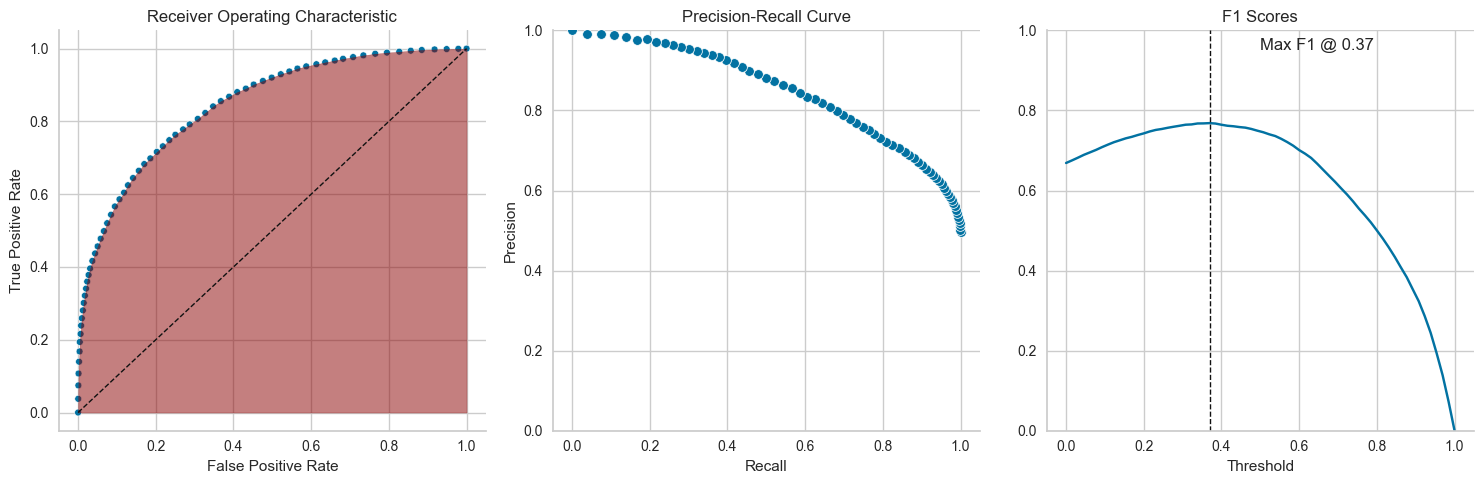

In [2]:
### Loading Data - Kings County Housing Data
house_sales = pd.read_csv('knn_data.csv')
house_sales = house_sales.drop(
    ['id','zipcode','lat','long','date'],axis = 1)
# 这里使用的drop函数的axis=1参数表示我们是在删除列，而不是行
house_sales.info()

### Select & Transform Features
# 资产价格一般呈现长尾分布
#distplot函数是用来绘制直方图并伴随一个核密度估计（Kernel Density Estimation, 简称KDE）曲线的
price_distribution = sns.distplot(house_sales.price) 
price_distribution.set(title = 'Distribution of House Price')
sns.despine()
plt.tight_layout()

### 对数据进行对数变换
# practical in coping with skewed data
X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales.price)
# 当处理到含0的数据集时，可以考虑使用loglp

## 对数转换后的价格直方图
logprice_distribution = sns.displot(y)
logprice_distribution.set(title = 'Distribution of House Log Price')
sns.despine()
plt.tight_layout()

# 使用mutual_info_regression函数计算X_all中每个特征与y的互信息
# 然后将结果转化为pandas Series，并以X_all的列名作为索引
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg
# 选择互信息最高的前10个特征
X = X_all.loc[:, mi_reg.iloc[:10].index]

# 使用pairplot为X中的每个特征与价格'y'绘制散点图
# X.assign(price = y) 临时在X数据框中增加一个'price'列
# y_vars指定Y轴变量，而x_vars指定X轴变量
# 临时把price加入X中，之后去掉
X = X.assign(price=y)
g = sns.pairplot(X, y_vars=['price'], x_vars=X.columns)
sns.despine()
X = X.drop( 'price' , axis = 1)

### Explore Correlations
X.info()
# 使用 Spearman 秩相关系数来计算 X 中每个特征与目标 y 之间的相关性。
# 将计算得到的相关系数值绘制为一个水平条形图。
Correl = X.apply(lambda x: spearmanr(x,y)[0])
Correl.sort_values().plot.barh()

### KNN Regression
# 对数据进行标准化（Z-score标准化），使得每个特征的均值为0，标准差为1
X_scaled = scale(X)
# 创建KNN回归模型实例
model = KNeighborsRegressor()
# 使用标准化后的数据来训练模型
model.fit(X=X_scaled, y=y)
# 使用训练好的模型预测数据
y_pred = model.predict(X_scaled)

### 回归误差指标
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error,
                             median_absolute_error,
                             explained_variance_score,
                             r2_score)

# 计算预测误差
# 误差是与真实值的偏差，而残差是与估计值（例如，对总体均值的估计）的偏差。
error = (y-y_pred).rename('Prediction Errors')
scores = dict(
    rmse = np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),  # 均方根误差
    rmsle = np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),  # 均方根对数误差
    mean_ae = mean_absolute_error(y_true=y, y_pred=y_pred),  # 平均绝对误差
    median_ae = median_absolute_error(y_true=y, y_pred=y_pred),  # 中位绝对误差
    # explained_variance = explained_variance_score(y_true=y, y_pred=y_pred),  # 解释的方差
    r2 = r2_score(y_true=y, y_pred=y_pred)  # R²得分
)

### 画图
# 使用matplotlib创建一个1行3列的子图，整体图形大小为15x4
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

# 在第一个子图上绘制实际值与预测值的散点图
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')             # 设置x轴标签为"Log Price"
axes[0].set_ylabel('Predictions')           # 设置y轴标签为"Predictions"
axes[0].set_ylim(11, 16)                    # 设置y轴的显示范围从11到16
axes[0].set_title('Predicted vs. Actuals')  # 设置第1个子图的标题为"Predicted vs. Actuals"

# 在第二个子图上绘制error的分布图
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')              # 设置第2个子图的标题为"Residuals"

# 在第三个子图上绘制scores的条形图
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')  # 设置第3个子图的标题为"Error Metrics"

# 为整体图形设置一个标题，标题大小为16
fig.suptitle('In-Sample Regression Errors', fontsize=16)

# 移除图形的上边框和右边框
sns.despine()

# 调整子图的布局，使其更加紧凑
fig.tight_layout()

# 调整整体标题的位置
fig.subplots_adjust(top=.88)



### 交叉验证
# 定义计算RMSE的函数
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true = y_true, y_pred = pred))

# 使用make_scorer函数创建一个RMSE评分器
rmse_score = make_scorer(rmse)

# 初始化一个字典来存储每个K值的交叉验证结果
cv_rmse = {}

# 创建一个列表来存储要测试的K值，从1开始，然后是5, 10, 15,..., 50
n_neighbors = [1] + list(range(5, 51, 5))

# 对每个K值进行交叉验证
for n in n_neighbors:
    # 创建一个Pipeline，包含两个步骤：1) 数据标准化，2) KNN回归
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=n))])
    
    # 使用cross_val_score函数进行5折交叉验证，并存储结果到cv_rmse字典中
    cv_rmse[n] = cross_val_score(pipe, 
                                X=X, 
                                y=y,
                                scoring=rmse_score,
                                cv=5)
    
# 将cv_rmse字典转换为DataFrame格式，方便后续的分析和绘图
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')

# 找到平均RMSE最小的K值和对应的RMSE
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()

# 调整数据框结构以适应seaborn绘图
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns =['n', 'fold', 'RMSE']

# 使用seaborn绘制每个K值的交叉验证结果
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)

# 设置图的标题，显示最佳K值和对应的RMSE
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}')



### 真实 VS 预测
# 使用 Pipeline 结合标准化处理和K近邻回归器
pipe = Pipeline([('scaler', StandardScaler()),  # 添加一个名为'scaler'的标准化处理步骤
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])  # 添加一个名为'knn'的K近邻回归步骤

# 使用5折交叉验证进行预测
y_pred = cross_val_predict(pipe, X, y, cv=5)

# 绘制 Y真实值 与 Y预测值 的散点图
ax = sns.scatterplot(x=y, y=y_pred)
# 创建一个真实值的范围
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
# 在同一图上绘制y=x的直线，代表完美预测
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred')


### 计算交叉验证的误差
error = (y - y_pred).rename('Prediction Errors')
# 计算并存储各种误差指标
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),  # 均方根误差
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),  # 对数均方根误差
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),  # 平均绝对误差
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),  # 中位绝对误差
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)  # 解释方差得分
)

# 创建一个1行3列的子图
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
# 在第一个子图中绘制真实值与预测值的散点图
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')  # 设置x轴标签
axes[0].set_ylabel('Predictions')  # 设置y轴标签
axes[0].set_ylim(11, 16)  # 设置y轴的范围
# 在第二个子图中绘制误差的分布图
sns.distplot(error, ax=axes[1])
# 在第三个子图中绘制误差指标的条形图
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')  
# 设置整体的标题
fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
# 调整子图的布局
fig.tight_layout()
# 调整整体标题的位置
plt.subplots_adjust(top=.8)




### 使用Pipeline结合GridSearchCV进行参数优化
# 创建一个Pipeline，首先进行标准化，然后用KNN回归
pipe = Pipeline([('scaler', StandardScaler()),  # 标准化数据
                 ('knn', KNeighborsRegressor())])  # KNN回归模型

# 设置交叉验证的折数为5
n_folds = 5
# 设置KNN回归中的邻居数量从5到100，每5个一跳
n_neighbors = tuple(range(5, 101, 5))

# 创建参数网格，用于GridSearchCV
param_grid = {'knn__n_neighbors': n_neighbors}

# 创建GridSearchCV估计器，用于寻找最佳参数
estimator = GridSearchCV(estimator=pipe,  # 使用上面定义的Pipeline
                         param_grid=param_grid,  # 参数网格
                         cv=n_folds,  # 交叉验证折数
                         scoring=rmse_score,  # 使用的评分标准是RMSE
                         # n_jobs=-1  # 使用所有可用的CPU核心
                        )
# 使用数据X和y来拟合GridSearchCV估计器
estimator.fit(X=X, y=y)

# 获取交叉验证的结果
cv_results = estimator.cv_results_

# 从cv_results中提取每一折的测试得分
test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)}, 
                           index=n_neighbors).stack().reset_index()
test_scores.columns = ['k', 'fold', 'RMSE']

# 计算每一个k的平均RMSE
mean_rmse = test_scores.groupby('k').RMSE.mean()
# 获取最佳的k和对应的最佳得分
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

# 使用Seaborn绘制交叉验证的结果
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
plt.title('Cross Validation Results')  # 设置图的标题
sns.despine()  # 去除图的顶部和右侧边框，使得可视化效果更好
plt.tight_layout()  # 自动调整子图参数，使得子图适应图的区域
plt.gcf().set_size_inches(10, 5)  # 设置图的大小

### 使用yellowbrick库来绘制训练和验证曲线
# 创建一个大图，用于绘制验证曲线
fig, ax = plt.subplots(figsize=(16, 9))

# 生成并显示验证曲线
val_curve = ValidationCurve(KNeighborsRegressor(),   # 使用KNN回归模型
                      param_name='n_neighbors',      # 需要调整的参数是邻居数量
                      param_range=n_neighbors,       # 参数的范围
                      cv=5,                          # 交叉验证折数
                      scoring=rmse_score,            # 使用的评分标准是RMSE
                        n_jobs=-1,                   # 使用所有可用的CPU核心
                      ax=ax)                         # 在上面创建的图上绘制
val_curve.fit(X, y)       # 使用数据X和y来拟合验证曲线
val_curve.poof()          # 显示图像
sns.despine()             # 去除图的顶部和右侧边框，使得可视化效果更好
fig.tight_layout()       # 自动调整子图参数，使得子图适应图的区域

# 创建另一个大图，用于绘制学习曲线
fig, ax = plt.subplots(figsize=(16, 9))

# 生成并显示学习曲线
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k),  # 使用之前找到的最佳邻居数量的KNN回归模型
                        train_sizes=np.arange(.1, 1.01, .1),      # 训练数据的大小范围
                        scoring=rmse_score,                        # 使用的评分标准是RMSE
                        cv=5,                                     # 交叉验证折数
                        n_jobs=-1,                              # 使用所有可用的CPU核心
                        ax=ax)                                    # 在上面创建的图上绘制
l_curve.fit(X, y)        # 使用数据X和y来拟合学习曲线
l_curve.poof()           # 显示图像
sns.despine()            # 去除图的顶部和右侧边框，使得可视化效果更好
fig.tight_layout();      # 自动调整子图参数，使得子图适应图的区域




### 使用KNN进行二分类任务

# 将y转换为二分类标签：如果y大于其中位数则为1，否则为0
y_binary = (y>y.median()).astype(int)

# 设置KNN分类器中的邻居数量从5到150，每10个一跳
n_neighbors = tuple(range(5, 151, 10))

# 设置交叉验证的折数为5
n_folds = 5

# 使用的评分标准是ROC曲线下面积
scoring = 'roc_auc'

# 创建一个Pipeline，首先进行标准化，然后用KNN分类器
pipe = Pipeline([('scaler', StandardScaler()),  # 标准化数据
                 ('knn', KNeighborsClassifier())])  # KNN分类模型

# 创建参数网格，用于GridSearchCV
param_grid = {'knn__n_neighbors': n_neighbors}

# 创建GridSearchCV估计器，用于寻找最佳参数
estimator = GridSearchCV(estimator=pipe,  # 使用上面定义的Pipeline
                         param_grid=param_grid,  # 参数网格
                         cv=n_folds,  # 交叉验证折数
                         scoring=scoring,  # 使用的评分标准是ROC曲线下面积
#                          n_jobs=-1  # 使用所有可用的CPU核心
                        )
# 使用数据X和y_binary来拟合GridSearchCV估计器
estimator.fit(X=X, y=y_binary)

# 获取最佳的邻居数量
best_k = estimator.best_params_['knn__n_neighbors']

# 创建一个大图，用于绘制验证曲线
fig, ax = plt.subplots(figsize=(16, 9))

# 生成并显示验证曲线
val_curve = ValidationCurve(KNeighborsClassifier(),   # 使用KNN分类模型
                      param_name='n_neighbors',       # 需要调整的参数是邻居数量
                      param_range=n_neighbors,        # 参数的范围
                      cv=n_folds,                     # 交叉验证折数
                      scoring=scoring,                # 使用的评分标准是ROC曲线下面积
#                       n_jobs=-1,                    # 使用所有可用的CPU核心
                      ax=ax)                          # 在上面创建的图上绘制
val_curve.fit(X, y_binary)  # 使用数据X和y_binary来拟合验证曲线
val_curve.poof()            # 显示图像
sns.despine()               # 去除图的顶部和右侧边框，使得可视化效果更好
fig.tight_layout()          # 自动调整子图参数，使得子图适应图的区域

# 创建另一个大图，用于绘制学习曲线
fig, ax = plt.subplots(figsize=(16, 9))

# 生成并显示学习曲线
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k),  # 使用之前找到的最佳邻居数量的KNN分类模型
                        train_sizes=np.arange(.1, 1.01, .1),       # 训练数据的大小范围
                        scoring=scoring,                            # 使用的评分标准是ROC曲线下面积
                        cv=5,                                      # 交叉验证折数
#                         n_jobs=-1,                               # 使用所有可用的CPU核心
                        ax=ax)                                     # 在上面创建的图上绘制
l_curve.fit(X, y_binary)   # 使用数据X和y_binary来拟合学习曲线
l_curve.poof()             # 显示图像
sns.despine()              # 去除图的顶部和右侧边框，使得可视化效果更好
fig.tight_layout()        # 自动调整子图参数，使得子图适应图的区域

### 引入所需的评价指标函数
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve)

# 使用交叉验证预测每个样本的概率（这里只提取为正类的概率）
y_score = cross_val_predict(KNeighborsClassifier(best_k), 
                           X=X, 
                           y=y_binary, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict_proba')[:, 1]

# 使用预测的概率构建字典
pred_scores = dict(y_true=y_binary,y_score=y_score)

# 计算ROC AUC
roc_auc_score(**pred_scores)

# 计算ROC曲线的各个值
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

# 计算Precision和Recall曲线的值
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

# 优化阈值以获得最大的F1分数
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()

# 绘制ROC、Precision-Recall、F1分数曲线
roc.info()

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout()


# 计算平均精度
average_precision_score(y_true=y_binary, y_score=y_score)

# 计算Brier分数
brier_score_loss(y_true=y_binary, y_prob=y_score)

# 使用最佳阈值转化概率为预测类别
y_pred = y_score > best_threshold
scores = dict(y_true=y_binary, y_pred=y_pred)

# 计算F-beta分数
fbeta_score(**scores, beta=1)

# 打印分类报告（包含精度、召回率、F1分数等）
print(classification_report(**scores))

# 计算混淆矩阵
confusion_matrix(**scores)
# 计算准确率
accuracy_score(**scores)
# 计算0-1损失
zero_one_loss(**scores)
# 计算Hamming损失
hamming_loss(**scores)
# 计算Cohen's Kappa
cohen_kappa_score(y1=y_binary, y2=y_pred)
# 计算Hinge损失
hinge_loss(y_true=y_binary, pred_decision=y_pred)
# 计算Jaccard相似度
jaccard_score(**scores)
# 计算Log Loss / 交叉熵损失
log_loss(**scores)
# 计算Matthews相关系数
matthews_corrcoef(**scores)

### Multi-Class 
y_multi = pd.qcut(y, q=3, labels=[0,1,2])
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'accuracy'
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         n_jobs=-1
                        )
estimator.fit(X=X, y=y_multi)

y_pred = cross_val_predict(estimator.best_estimator_, 
                           X=X, 
                           y=y_multi, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict')
print(classification_report(y_true=y_multi, y_pred=y_pred))



### 使用多分类方法

# 将连续的y值分为3个区间，每个区间对应一个类标签
y_multi = pd.qcut(y, q=3, labels=[0,1,2])

# 设置KNN分类器中的邻居数量从5到150，每10个一跳
n_neighbors = tuple(range(5, 151, 10))

# 设置交叉验证的折数为5
n_folds = 5

# 使用的评分标准是准确度
scoring = 'accuracy'

# 创建一个Pipeline，首先进行标准化，然后用KNN分类器
pipe = Pipeline([('scaler', StandardScaler()),  # 标准化数据
                 ('knn', KNeighborsClassifier())])  # KNN分类模型

# 创建参数网格，用于GridSearchCV
param_grid = {'knn__n_neighbors': n_neighbors}

# 创建GridSearchCV估计器，用于寻找最佳参数
estimator = GridSearchCV(estimator=pipe,  # 使用上面定义的Pipeline
                         param_grid=param_grid,  # 参数网格
                         cv=n_folds,  # 交叉验证折数
                         n_jobs=-1  # 使用所有可用的CPU核心
                        )

# 使用数据X和y_multi来拟合GridSearchCV估计器
estimator.fit(X=X, y=y_multi)

# 使用交叉验证预测每个样本的类标签
y_pred = cross_val_predict(estimator.best_estimator_, 
                           X=X, 
                           y=y_multi, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict')

# 打印分类报告（包含精度、召回率、F1分数等）
print(classification_report(y_true=y_multi, y_pred=y_pred))